# Self-supervised FCNs for Monocular Depth-estimation
##### *Oliver Tattersall (omtatter@uwaterloo.ca), Owen Waldron (orpwaldr@uwaterloo.ca)*



Plan:
1. read some more papers and find all the datasets
  a) we can use resnet50 as encoder, and then I think we build a more complicated decoder
2. try to see if we can get an overfitted model to work
3. try to see if we can extend that model
4. Great Success


## Abstract

TODO

## Team Members & Contributions

- Oliver Tattersall (omtatter@uwaterloo.ca)
    - Loss Functions, Training Loop
- Owen Waldron (orpwaldr@uwaterloo.ca)
    - Data Synthesis, Model


## Code Libraries

In [376]:

import random # Used in data augmentation
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries.
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from torchvision.datasets._stereo_matching import Kitti2015Stereo
import torchvision.models as models

## Data Synthesis

We will be using the [KITTI stereo dataset](https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo) for stereo disparity pairs. 

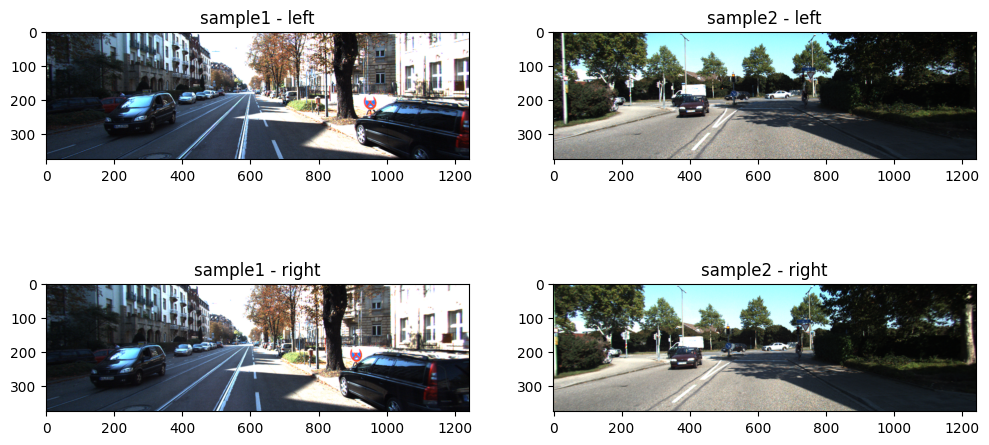

In [377]:
# Importing the KITTY dataset

DATASET_PATH = 'datasets'

# Create a dataloader to load in images
sample1 = Kitti2015Stereo(DATASET_PATH)[0]
sample2 = Kitti2015Stereo(DATASET_PATH)[15]

left1, right1 = sample1[0:2]
left2, right2 = sample2[0:2]

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - left')
ax1.imshow(left1)
ax2 = fig.add_subplot(2,2,3)
plt.title('sample1 - right')
ax2.imshow(right1)
ax3 = fig.add_subplot(2,2,2)
plt.title('sample2 - left')
ax3.imshow(left2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - right')
ax4.imshow(right2)


To augment training data, we first prepare the following transformations that follow the `StereoMatchingDataset` API. Note that that `StereoMatchingDataset` applies the transformations to the left & right images, as well as the disparities & valid_masks. These last two aren't used in training, so we do not bother transforming them in our `RandomResizeCrop` transformation.

In [378]:
# Converts the PIL image to a tensor
class ToTensor():
    def __call__(self, images, disparities, valid_masks):
        return (tF.to_tensor(images[0]), tF.to_tensor(images[1])), (disparities[0][:, 100, 100], disparities[0][:, 100, 100]), valid_masks

# Flips images horizontally at random (& swaps left and right)
class RandomFlip():
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, images, disparities, valid_masks):
        if random.random() < self.p:
            return (tF.hflip(images[1]), tF.hflip(images[0])), disparities, valid_masks
        return images, disparities, valid_masks

# Scales, crops, and resizes a random portion of the image
class RandomResizeCrop():
    def __init__(self, minimum_scale, maximum_scale, height, width):
        self.rando = np.random.default_rng()
        self.min_scale = minimum_scale
        self.max_scale = maximum_scale
        self.height = height
        self.width = width
        self.size = [height, width]

    def __call__(self, images, disparities, valid_masks):
        height = images[0].height
        width = images[0].width

        scale = (self.max_scale - self.min_scale) * self.rando.random() + self.min_scale
        scale = min(scale, height / self.height, width / self.width)
        new_height = int(height * scale)
        new_width = int(width * scale)

        new_img_left = tF.resize(images[0], [new_height, new_width])
        new_img_right = tF.resize(images[1], [new_height, new_width])

        top = self.rando.integers(low=0, high=new_height-self.height + 1)
        left = self.rando.integers(low=0, high=new_width-self.width + 1)

        return (tF.resized_crop(new_img_left, top, left, self.height, self.width, self.size), 
                tF.resized_crop(new_img_right, top, left, self.height, self.width, self.size)), disparities, valid_masks

class CropToMultiple():
    def __init__(self, mult):
        self.mult = mult
    def __call__(self, images, disparities, valid_masks):
        height = (images[0].height // self.mult) * self.mult
        width = (images[0].width // self.mult) * self.mult
        size = [height, width]
        return (tF.center_crop(images[0], size), tF.center_crop(images[1], size)), disparities, valid_masks

class JointCompose():
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, images, disparities, valid_masks):
        for t in self.transforms:
            images, disparities, valid_masks = t(images, disparities, valid_masks)
        return images, disparities, valid_masks

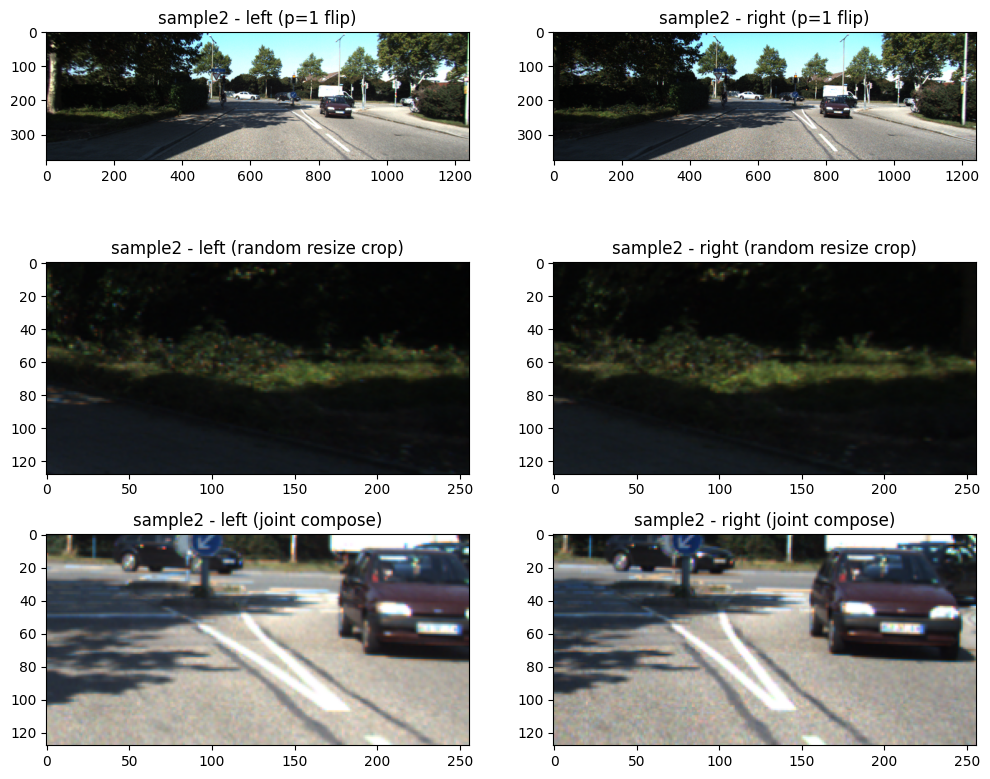

In [379]:

base = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
)[15]
flipped = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([RandomFlip(p=1)]),
)[15]
resized = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([RandomResizeCrop(0.75, 1.25, 128, 256)]),
)[15]
joint = Kitti2015Stereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([RandomFlip(p=1), RandomResizeCrop(0.75, 1.25, 128, 256)]),
)[15]

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(3,2,1)
plt.title('sample2 - left (p=1 flip)')
ax1.imshow(flipped[0])
ax1 = fig.add_subplot(3,2,2)
plt.title('sample2 - right (p=1 flip)')
ax1.imshow(flipped[1])
ax1 = fig.add_subplot(3,2,3)
plt.title('sample2 - left (random resize crop)')
ax1.imshow(resized[0])
ax1 = fig.add_subplot(3,2,4)
plt.title('sample2 - right (random resize crop)')
ax1.imshow(resized[1])
ax1 = fig.add_subplot(3,2,5)
plt.title('sample2 - left (joint compose)')
ax1.imshow(joint[0])
ax1 = fig.add_subplot(3,2,6)
plt.title('sample2 - right (joint compose)')
ax1.imshow(joint[1])

We will have 4 seperate data loaders. The first 3 will use the KITTI 2015 stereo as a sanity test, and the last will use a dataset that features ground truth disparity maps. 

In [380]:
class KittiStereo(Dataset):
    def __init__(self, *args, **kwargs):
        self.base_dataset = Kitti2015Stereo(*args, **kwargs)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        return data[:2]  # Only return the first two items (left & right images)

In [381]:
sanity_data =Subset(KittiStereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
), indices=[15])

train_data = KittiStereo(
    DATASET_PATH, 
    split = 'train', 
    transforms = JointCompose([RandomFlip(), RandomResizeCrop(1, 1, 128, 256), ToTensor()])
)

val_data = KittiStereo(
    DATASET_PATH, 
    split='test',
    transforms = JointCompose([ToTensor()])
)

val_gts_data = (
    # TODO
)

TRAIN_BATCH_SIZE = 4

sanity_loader = DataLoader(sanity_data, batch_size=1,shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)
val_gts_loader = DataLoader(val_gts_data, batch_size=1, shuffle=False) # TODO

## Model

We will use the fully convolutional network described by the paper referenced in the slides. The model devides into an encoder and decoder. At a high level, the encoder recognizes featueres and the decoder reconstructs a disparity map given these identified features. The decoder uses *transposed convolutions* to learn how to upsample at each step, instead of just upsampling via bilinear interpolation, for example.

In [382]:
### model
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Miscelaneous functions
        self.act_fn = nn.ReLU(inplace=True)
        self.disp_act_fn = nn.Sigmoid()
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')

        # Encoder
        self.conv1  = nn.Conv2d(3  , 32 , kernel_size=7, stride=2, padding=3)
        self.conv1b = nn.Conv2d(32 , 32 , kernel_size=7, stride=1, padding=3)

        self.conv2  = nn.Conv2d(32 , 64 , kernel_size=5, stride=2, padding=2)
        self.conv2b = nn.Conv2d(64 , 64 , kernel_size=5, stride=1, padding=2)

        self.conv3  = nn.Conv2d(64 , 128, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv4  = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4b = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv5  = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)


        self.conv6  = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv6b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        self.conv7  = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv7b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.upconv7 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv7  =          nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.upconv6 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv6  =          nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv5  =          nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv4  =          nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.disp4   =          nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv3  =          nn.Conv2d(128 + 2, 64, kernel_size=3, stride=1, padding=1)
        self.disp3   =          nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv2  =          nn.Conv2d(64 + 2, 32, kernel_size=3, stride=1, padding=1)
        self.disp2   =          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv1  =          nn.Conv2d(16 + 2, 16, kernel_size=3, stride=1, padding=1)
        self.disp1   =          nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, left_image):
        # Encoder
        # Note how some layer are cached for skip connections
        conv1  = self.act_fn(self.conv1(left_image))
        conv1b = self.act_fn(self.conv1b(conv1))
        conv2  = self.act_fn(self.conv2(conv1b))
        conv2b = self.act_fn(self.conv2b(conv2))
        conv3  = self.act_fn(self.conv3(conv2b))
        conv3b = self.act_fn(self.conv3b(conv3))
        conv4  = self.act_fn(self.conv4(conv3b))
        conv4b = self.act_fn(self.conv4b(conv4))
        conv5  = self.act_fn(self.conv5(conv4b))
        conv5b = self.act_fn(self.conv5b(conv5))
        conv6  = self.act_fn(self.conv6(conv5b))
        conv6b = self.act_fn(self.conv6b(conv6))
        conv7  = self.act_fn(self.conv7(conv6b))
        conv7b = self.act_fn(self.conv7b(conv7))

        # Decoder
        upconv7 = self.act_fn(self.upconv7(conv7b))
        iconv7  = self.act_fn(self.iconv7(torch.cat([upconv7, conv6b], dim=1)))
        upconv6 = self.act_fn(self.upconv6(iconv7))
        iconv6  = self.act_fn(self.iconv6(torch.cat([upconv6, conv5b], dim=1)))
        upconv5 = self.act_fn(self.upconv5(iconv6))
        iconv5  = self.act_fn(self.iconv5(torch.cat([upconv5, conv4b], dim=1)))  
        upconv4 = self.act_fn(self.upconv4(iconv5)) 
        iconv4  = self.act_fn(self.iconv4(torch.cat([upconv4, conv3b], dim=1)))  
        disp4   = 0.3 * self.disp_act_fn(self.disp4(iconv4))
        upconv3 = self.act_fn(self.upconv3(iconv4))
        iconv3  = self.act_fn(self.iconv3(torch.cat([upconv3, conv2b, self.upsample2(disp4)], dim=1)))
        disp3   = 0.3 * self.disp_act_fn(self.disp3(iconv3))
        upconv2 = self.act_fn(self.upconv2(iconv3))
        iconv2  = self.act_fn(self.iconv2(torch.cat([upconv2, conv1b, self.upsample2(disp3)], dim=1))) 
        disp2   = 0.3 * self.disp_act_fn(self.disp2(iconv2))  
        upconv1 = self.act_fn(self.upconv1(iconv2))
        iconv1  = self.act_fn(self.iconv1(torch.cat([upconv1, self.upsample2(disp2)], dim=1)))
        disp1 = 0.3 * self.disp_act_fn(self.disp1(iconv1))

        return disp1

## Reconstructing the image from the disparity

In [383]:
import tensorflow as tf

@tf.function
def bilinear_sampler_1d_h(input_images, x_offset, wrap_mode='border'):
    def _repeat(x, n_repeats):
        rep = tf.tile(tf.expand_dims(x, 1), [1, n_repeats])
        return tf.reshape(rep, [-1])

    def _interpolate(im, x, y):
        if wrap_mode == 'border':
            im = tf.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
            x += 1
            y += 1
            edge_size = 1
        elif wrap_mode == 'edge':
            edge_size = 0
        else:
            raise ValueError("Unsupported wrap_mode: %s" % wrap_mode)

        x = tf.clip_by_value(x, 0.0, tf.cast(width - 1 + 2 * edge_size, tf.float32))

        x0_f = tf.floor(x)
        x1_f = x0_f + 1

        x0 = tf.cast(x0_f, tf.int32)
        x1 = tf.cast(tf.minimum(x1_f, tf.cast(width - 1 + 2 * edge_size, tf.float32)), tf.int32)
        y0 = tf.cast(tf.floor(y), tf.int32)

        dim2 = width + 2 * edge_size
        dim1 = dim2 * (height + 2 * edge_size)
        base = _repeat(tf.range(num_batch) * dim1, height * width)
        base_y0 = base + y0 * dim2

        idx_l = base_y0 + x0
        idx_r = base_y0 + x1

        im_flat = tf.reshape(im, [-1, num_channels])
        pix_l = tf.gather(im_flat, idx_l)
        pix_r = tf.gather(im_flat, idx_r)

        weight_l = tf.expand_dims(x1_f - x, 1)
        weight_r = tf.expand_dims(x - x0_f, 1)

        return weight_l * pix_l + weight_r * pix_r

    def _transform(input_images, x_offset):
        x_t, y_t = tf.meshgrid(
            tf.linspace(0.0, tf.cast(width - 1, tf.float32), width),
            tf.linspace(0.0, tf.cast(height - 1, tf.float32), height)
        )

        x_t_flat = tf.reshape(x_t, (1, -1))
        y_t_flat = tf.reshape(y_t, (1, -1))

        x_t_flat = tf.tile(x_t_flat, [num_batch, 1])
        y_t_flat = tf.tile(y_t_flat, [num_batch, 1])

        x_t_flat = tf.reshape(x_t_flat, [-1])
        y_t_flat = tf.reshape(y_t_flat, [-1])

        x_offset_scaled = tf.reshape(x_offset, [-1]) * tf.cast(width, tf.float32)
        x_t_flat += x_offset_scaled

        interpolated = _interpolate(input_images, x_t_flat, y_t_flat)

        return tf.reshape(interpolated, [num_batch, height, width, num_channels])

    # Extract shapes
    num_batch = tf.shape(input_images)[0]
    height = tf.shape(input_images)[1]
    width = tf.shape(input_images)[2]
    num_channels = tf.shape(input_images)[3]

    output = _transform(input_images, x_offset)
    return output

In [384]:
import torch
import torch.nn.functional as F

def bilinear_sampler_1d_h(img, x_offset, wrap_mode='border'):
    """
    img:         Tensor of shape [B, C, H, W] (PyTorch uses channel-first).
    x_offset:    Disparity tensor of shape [B, 1, H, W] with values in [-1, 1].
                 These are normalized horizontal offsets.
    wrap_mode:   Either 'border' (which pads the image at the borders) or 'edge'.
                 (Here we treat both as using grid_sample's 'border' option.)
    """
    
    # Get shape; note that TensorFlow's version uses [B, H, W, C],
    # but here we assume [B, C, H, W].
    B, C, H, W = img.size()
    device = img.device

    # Ensure x_offset is [B, H, W] by squeezing the channel dim if needed.
    if x_offset.dim() == 4 and x_offset.size(1) == 1:
        x_offset = x_offset.squeeze(1)  # now shape [B, H, W]
    
    # Create meshgrid in pixel coordinates.
    # In TF, the meshgrid goes from 0 to width-1 and 0 to height-1.
    # We use torch.arange and torch.meshgrid to build similar grids.
    # We set indexing='ij' so that the first output corresponds to rows (y) and the second to columns (x).
    y_grid, x_grid = torch.meshgrid(
        torch.arange(H, device=device).float(),
        torch.arange(W, device=device).float(),
        indexing='ij'
    )  # both of shape [H, W]
    
    # Expand to batch size.
    # x_grid and y_grid become [B, H, W] (each identical across the batch).
    x_grid = x_grid.unsqueeze(0).expand(B, H, W)
    y_grid = y_grid.unsqueeze(0).expand(B, H, W)

    # Scale the normalized x_offset into pixel units.
    # (In the TF code: x_offset_scaled = reshape(x_offset)*width)
    x_offset_scaled = x_offset * W
    
    # Add the offset to the original x coordinates. This mirrors:
    #     x_t_flat += x_offset_scaled 
    # in the TF function.
    x_new = x_grid + x_offset_scaled

    # Now we have new pixel coordinates (x_new, y_grid).
    # Next, convert these pixel coordinates to normalized coordinates for grid_sample.
    # The conversion is: normalized_x = (2*x_pixel/(W - 1)) - 1, similar for y.
    x_norm = 2 * x_new / (W - 1) - 1
    y_norm = 2 * y_grid / (H - 1) - 1

    # Construct the sampling grid. grid_sample expects a grid of shape [B, H, W, 2],
    # with the last dimension giving (x, y) in normalized coordinates.
    # Notice that we stack x_norm and y_norm so that at each location the offset is applied only on x.
    grid = torch.stack((x_norm, y_norm), dim=3)  # shape: [B, H, W, 2]

    # For wrap_mode, grid_sample provides several options:
    # - padding_mode='border' returns the border value for out-of-bound coordinates.
    # We choose 'border' to match the TF pad+clip behavior.
    pad_mode = 'border' if wrap_mode == 'border' else 'border'  # (You may adjust if you want 'edge')

    # Use grid_sample to perform bilinear interpolation.
    # Note: align_corners=True makes the normalized coordinates correspond exactly to pixel centers.
    output = F.grid_sample(img, grid, mode='bilinear', padding_mode=pad_mode, align_corners=True)
    
    return output


In [385]:
import torch
import torch.nn.functional as F

def bilinear_sampler_1d_2h(img, disp, wrap_mode='border'):
    """
    Args:
        img: (B, C, H, W) input image (e.g. left image)
        disp: (B, 1, H, W) disparity map (e.g. right disparity, applied to the left image)
        wrap_mode: 'border' or 'edge' padding

    Returns:
        Warped image: (B, C, H, W)
    """

    B, C, H, W = img.shape

    # Normalize disparity to [-1, 1]
    # Because grid_sample expects coords in [-1, 1]
    # We normalize by dividing by (W - 1) and scale to [-1, 1]
    # Disparity is subtracted because we're doing backward warping
    x_base = torch.linspace(-1.0, 1.0, W, device=img.device).view(1, 1, 1, W).expand(B, -1, H, -1)
    y_base = torch.linspace(-1.0, 1.0, H, device=img.device).view(1, 1, H, 1).expand(B, -1, -1, W)

    # Convert disparity from pixels to normalized coords
    disp_norm = disp / ((W - 1.0) / 2.0)  # scale to [-1, 1]
    x_shifted = x_base - disp_norm  # Subtract because we're sampling from the source

    # Combine x and y into grid
    grid = torch.cat((x_shifted, y_base), dim=1)  # shape (B, 2, H, W)
    grid = grid.permute(0, 2, 3, 1)  # shape (B, H, W, 2)

    # Bilinear sampling
    return F.grid_sample(img, grid, mode='bilinear', padding_mode=wrap_mode, align_corners=True)


## leftIm defines if we are reconstructing the left image or the right image
def reconStruct(im, disp, leftIm):
    if(leftIm):
        return bilinear_sampler_1d_h(im ,-1*disp)
    else:
        return bilinear_sampler_1d_h(im, disp)


In [386]:
import torch
import tensorflow as tf

# def convert_torch_to_tf(image_torch: torch.Tensor, disparity_torch: torch.Tensor):
#     # Convert to NumPy, transpose to [B, H, W, C], and convert to tf.Tensor
#     image_np = image_torch.permute(0, 2, 3, 1).cpu().numpy()  # [B, H, W, C]
#     disparity_np = disparity_torch.permute(0, 2, 3, 1).cpu().numpy()  # [B, H, W, 1]

#     image_tf = tf.convert_to_tensor(image_np, dtype=tf.float32)
#     disparity_tf = tf.convert_to_tensor(disparity_np, dtype=tf.float32)
#     disparity_tf = tf.squeeze(disparity_tf, axis=-1)  # [B, H, W]

#     return image_tf, disparity_tf

def convert_torch_to_tf(image, disp):
    return image.permute(0, 2, 3, 1).cpu(), disp.permute(0, 2, 3, 1).cpu()
    # return tf.convert_to_tensor(image.permute(0, 2, 3, 1)), tf.convert_to_tensor(disp.permute(0, 2, 3, 1))


Example on a ground truth image

tensor(0.0365) tensor(0.) tensor(0.0176)
torch.Size([3, 288, 384])
torch.Size([3, 288, 384])


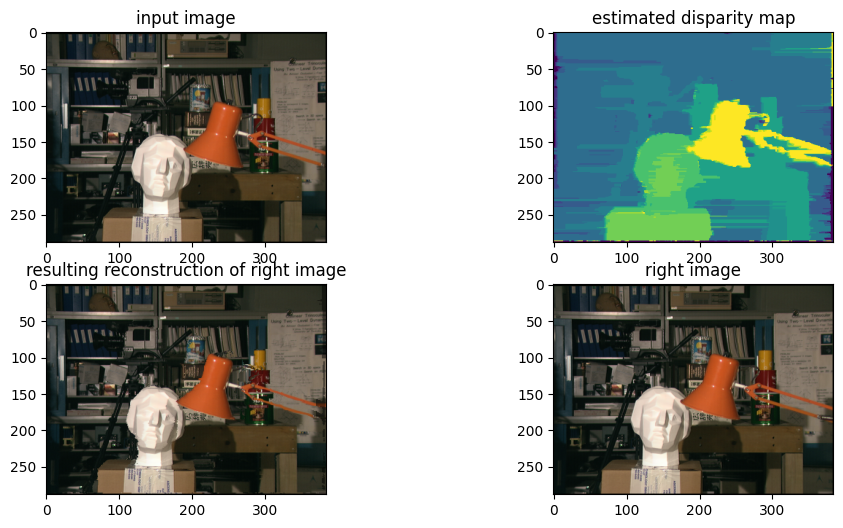

In [387]:
imL = Image.open("images/tsukuba/scene1.row3.col3.ppm")
# imL = Image.open("Backpack-perfect/im0.png")
gt = Image.open("images/tsukuba/truedisp.row3.col3.pgm")
# gt = Image.open("Backpack-perfect/disp0.pfm")
gt = np.load("images/tsukuba/resMap.pgm").astype(np.float32)
# gt = np.astype(gt, np.float32)
gt = tF.to_tensor(gt)
# print(gt.shape)
gt = gt/gt.shape[2]
print(torch.max(gt), torch.min(gt), torch.mean(gt))

tensIml = tF.to_tensor(imL)[None]

# gt[gt==float("inf")] = 0
# gt = gt
# gt = tF.to_pil_image(gt)


imR = Image.open("images/tsukuba/scene1.row3.col4.ppm")
# imR = Image.open("Backpack-perfect/im1.png")

# print(np.max(gt))
# print(torch.unique(tF.to_tensor(gt)))
# print()

print(tF.to_tensor(imL).shape)
# print(tF.to_tensor(gt).shape)
# print(generate_image_right(tF.to_tensor(im)[None], tF.to_tensor(gt)[None]).shape)
# regen_im = generate_image_right(tF.to_tensor(imL)[None], tF.to_tensor(gt)[None])[0]
regen_im = reconStruct(tensIml, gt[None], False)[0]
# regen_im = reconStruct(*convert_torch_to_tf(tensIml, gt[None]), False)[0]
gt = gt.permute(1, 2, 0)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("input image")
ax1.imshow(imL)
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("estimated disparity map")
ax2.imshow(gt)
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("resulting reconstruction of right image")
print(regen_im.shape)
ax3.imshow(regen_im.permute(1, 2, 0))
# ax3.imshow(regen_im)
ax3 = fig.add_subplot(2, 2, 4)
ax3.set_title("right image")
ax3.imshow(imR)




## Loss Function

source of loss function:
from paper

Difficulties with loss function:
- keeping the loss function only with tensor operations to keep the .backward() functionality valid

In [388]:

# from pytorch_ssim import SSIM 
# from ignite.metrics import SSIM # TODO add an installation guide for this
import torch # delete this later


# def SSIM(self, x, y):
#     C1 = 0.01 ** 2
#     C2 = 0.03 ** 2

#     mu_x = slim.avg_pool2d(x, 3, 1, 'VALID')
#     mu_y = slim.avg_pool2d(y, 3, 1, 'VALID')

#     sigma_x  = slim.avg_pool2d(x ** 2, 3, 1, 'VALID') - mu_x ** 2
#     sigma_y  = slim.avg_pool2d(y ** 2, 3, 1, 'VALID') - mu_y ** 2
#     sigma_xy = slim.avg_pool2d(x * y , 3, 1, 'VALID') - mu_x * mu_y

#     SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
#     SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

#     SSIM = SSIM_n / SSIM_d

#     return tF.clip_by_value((1 - SSIM) / 2, 0, 1)

def ssim(img1, img2):
    """Simplified SSIM using a 3x3 filter."""
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, 3, 1, 1)
    mu2 = F.avg_pool2d(img2, 3, 1, 1)

    sigma1 = F.avg_pool2d(img1 * img1, 3, 1, 1) - mu1 ** 2
    sigma2 = F.avg_pool2d(img2 * img2, 3, 1, 1) - mu2 ** 2
    sigma12 = F.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2))
    return torch.clamp((1 - ssim_map) / 2, 0, 1)
    # return ssim_map

def gradient_x(img):
    return img[:, :, :, :-1] - img[:, :, :, 1:]

def gradient_y(img):
    return img[:, :, :-1, :] - img[:, :, 1:, :]


def appearance_loss(img, recon, alpha):
    l1 = torch.abs(img - recon)
    ssim_loss = ssim(img, recon) #(1 - SSIM)/2 built in already
    return (alpha * ssim_loss.mean()) + (1-alpha)*l1.mean()
    return (alpha * (1 - ssim_loss.mean()) / 2) + ((1 - alpha) * l1.mean())

# def appearance_loss(img, recon, alpha):
#     return torch.square(img - recon).sum()/(img.shape[2]*img.shape[3])

def disparity_smoothness(disp, img):
    disp_grad_x = gradient_x(disp)
    disp_grad_x[torch.isinf(disp_grad_x)] = 0
    disp_grad_x[torch.isnan(disp_grad_x)] = 0
    disp_grad_y = gradient_y(disp)
    disp_grad_y[torch.isinf(disp_grad_y)] = 0
    disp_grad_y[torch.isnan(disp_grad_y)] = 0
    img_grad_x = gradient_x(img)
    img_grad_y = gradient_y(img)

    # print(img_grad_x.shape)
    
    weights_x = torch.exp(-torch.sum(torch.abs(img_grad_x), 1, keepdim=True))
    weights_y = torch.exp(-torch.sum(torch.abs(img_grad_y), 1, keepdim=True))

    smoothness_x = torch.abs(disp_grad_x * weights_x)
    smoothness_y = disp_grad_y * weights_y
    # print(torch.isnan(smoothness_x).any())
    return smoothness_x.abs().mean() + smoothness_y.abs().mean()



def lr_consistency_loss(disp_left, disp_right):
    """
    Args:
        disp_left:  [B, 1, H, W] disparity map from left view (predicts right image)
        disp_right: [B, 1, H, W] disparity map from right view (predicts left image)

    Returns:
        Scalar tensor representing left-right consistency loss.
    """

    # if it comes in as [1, H, W] instead
    # disp_left, disp_right = disp_left[None], disp_right[None]

    B, _, H, W = disp_left.shape

    # Create normalized horizontal coordinate grid
    grid_x = torch.linspace(-1.0, 1.0, W).view(1, 1, 1, W).expand(B, 1, H, W).to(disp_left.device)
    grid_y = torch.linspace(-1.0, 1.0, H).view(1, 1, H, 1).expand(B, 1, H, W).to(disp_left.device)

    # Normalize disparity to [-1, 1] range
    disp_left_norm = disp_left / ((W - 1) / 2)
    disp_right_norm = disp_right / ((W - 1) / 2)

    # Sample right disparity using left disparity to warp
    grid_warped_right = torch.cat([grid_x - disp_left_norm, grid_y], dim=1)
    grid_warped_right = grid_warped_right.permute(0, 2, 3, 1)  # [B, H, W, 2]
    sampled_right = F.grid_sample(disp_right, grid_warped_right, mode='bilinear', padding_mode='border', align_corners=True)

    # Sample left disparity using right disparity to warp
    grid_warped_left = torch.cat([grid_x + disp_right_norm, grid_y], dim=1)
    grid_warped_left = grid_warped_left.permute(0, 2, 3, 1)
    sampled_left = F.grid_sample(disp_left, grid_warped_left, mode='bilinear', padding_mode='border', align_corners=True)

    # L1 loss between disparity and its warped counterpart
    # print(torch.isinf(disp_left).any())
    loss_left = torch.abs(disp_left - sampled_right).mean()
    loss_right = torch.abs(disp_right - sampled_left).mean()

    return loss_left + loss_right


def custom_loss(imL, imR, dL, dR, recImL, recImR, alpha=0.85, alpha_ap=1.0, alpha_ds=0.1, alpha_lr=0.1):

    loss_ap = appearance_loss(imL, recImL, alpha) + appearance_loss(imR, recImR, alpha)
    print("loss_ap", loss_ap)

    loss_ds = disparity_smoothness(dL, imL) + disparity_smoothness(dR, imR)
    print("loss_ds", loss_ds)

    loss_lr = lr_consistency_loss(dL, dR)
    if(torch.isnan(loss_lr)):
        # penalty to discourage infinite disparity
        loss_lr = 1000000000000
    # --- Total Loss ---
    print("loss_lr", loss_lr)
    total_loss = alpha_ap * loss_ap + alpha_ds * loss_ds + alpha_lr * loss_lr
    # total_loss = alpha_ap * loss_ap  + alpha_lr * loss_lr
    return total_loss



Testing the loss function

In [389]:
imL =tF.to_tensor(Image.open("Backpack-perfect/im0.png"))[None]
imR =tF.to_tensor(Image.open("Backpack-perfect/im1.png"))[None]
dL = tF.to_tensor(Image.open("Backpack-perfect/disp0.pfm"))[None]
dL[torch.isinf(dL)] = 0
dR = tF.to_tensor(Image.open("Backpack-perfect/disp1.pfm"))[None]
dR[torch.isinf(dR)] = 0
dL = dL/dL.shape[3]
dR = dR/dR.shape[3]
poop = torch.zeros(dL.shape)

print("Bad loss: ", custom_loss(imL, imR, poop, poop, reconStruct(imR, poop, True), reconStruct(imL, poop, False)))

print("Good loss: ", custom_loss(imL, imR, dL, dR, reconStruct(imR, dR, True), reconStruct(imL, dL, False)))

loss_ap tensor(0.3326)
loss_ds tensor(0.)
loss_lr tensor(0.)
Bad loss:  tensor(0.3326)
loss_ap tensor(0.2281)
loss_ds tensor(0.0033)
loss_lr tensor(0.0125)
Good loss:  tensor(0.2297)


In [390]:
# maybe add later
def disparity_image_loss(im, disp, lmbda = 1, sig = 1):
    """
    im: [3, H, W] image
    disp: [H, W] image
    """

## Validation

In [391]:
# validate the output disparity map against the ground truth
def validateAgainstGroundTruthSingle(dl, gt):
    #idk how im going to do this yet, will need to figure out dimensions and shit
    return 0.5

def validateAgainstGroundTruth(val_loader, net):
    net = net.cuda()
    ttlDiff = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):

            imL, imR, gtDl, gtDr = data
            # if USE_GPU:
            imL, imR, gtDl, gtDr = imL.cuda(), imR.cuda(), gtDl.cuda(), gtDr.cuda()

            dL, dR = net.forward(imL)
            ttlDiff += validateAgainstGroundTruthSingle(dL, gtDl) + validateAgainstGroundTruthSingle(dR, gtDr)
    
    return ttlDiff/(2*len(val_loader))



def validate(val_loader, net, loss_function = custom_loss):

    net.eval()
    val_loss = 0

    # if USE_GPU:
    net = net.cuda()
    with torch.no_grad():
        for i, data in enumerate(val_loader):

            imL, imR, gtDl, gtDr = data
            # if USE_GPU:
            imL, imR, gtDl, gtDr = imL.cuda(), imR.cuda(), gtDl.cuda(), gtDr.cuda()


            dL, dR = net.forward(imL)
            val_loss += loss_function(imL, imR, dL, dR, reconStruct(imL, dR, True), reconStruct(imR, dL, False)).item()

    # return the values of loss and mIOU (averaged over the loaded data)
    return val_loss/len(val_loader.dataset)


## Trainer


In [392]:
def train(train_loader, net, optimizer, loss_graph, loss_function = custom_loss):

    net.train()
    # if USE_GPU:
    net = net.cuda()
    val_loss = 0
    for i, data in enumerate(train_loader):

        imL, imR = data
        # if USE_GPU:
        imL, imR = imL.cuda(), imR.cuda()

        optimizer.zero_grad()
        output = net.forward(imL)
        dL, dR = output[:, torch.newaxis,  0], output[:, torch.newaxis, 1]
        
        # reconL = reconStruct(*convert_torch_to_tf(imR, dR), True)
        # reconR = reconStruct(*convert_torch_to_tf(imL, dL), False)

        main_loss = loss_function(imL, imR, dL, dR, reconStruct(imR, dR, True), reconStruct(imL, dL, False))
        # main_loss = loss_function(imL, imR, dL, dR, reconL, reconR)
        loss = main_loss.item()
        val_loss += loss
        loss_graph.append(loss)
        main_loss.backward()
        optimizer.step()
        # loss_graph.append() Populate this list to graph the loss

    # Return the value of loss (averaged over the loaded data)
    return val_loss/len(train_loader)

In [393]:
def train_net(loader, net, optimizer, EPOCH):
    net.train()

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)

    for e in range(EPOCH):
        loss = train(loader, net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

## Overfit model
First, we are going to train an overfit net to a single image to get a sanity check that the error function and model are working as intended

In [394]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
    return optimizer

Starting Training...
loss_ap tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)
loss_ds tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
loss_lr tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0 Loss: 0.6260871291160583
loss_ap tensor(0.6258, device='cuda:0', grad_fn=<AddBackward0>)
loss_ds tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
loss_lr tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1 Loss: 0.625945508480072
loss_ap tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)
loss_ds tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
loss_lr tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2 Loss: 0.6256838440895081
loss_ap tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)
loss_ds tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
loss_lr tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3 Loss: 0.6253551840782166
loss_ap tensor(0.6248, device='cuda:0', grad_fn=<AddBackward0>)
loss_ds tens

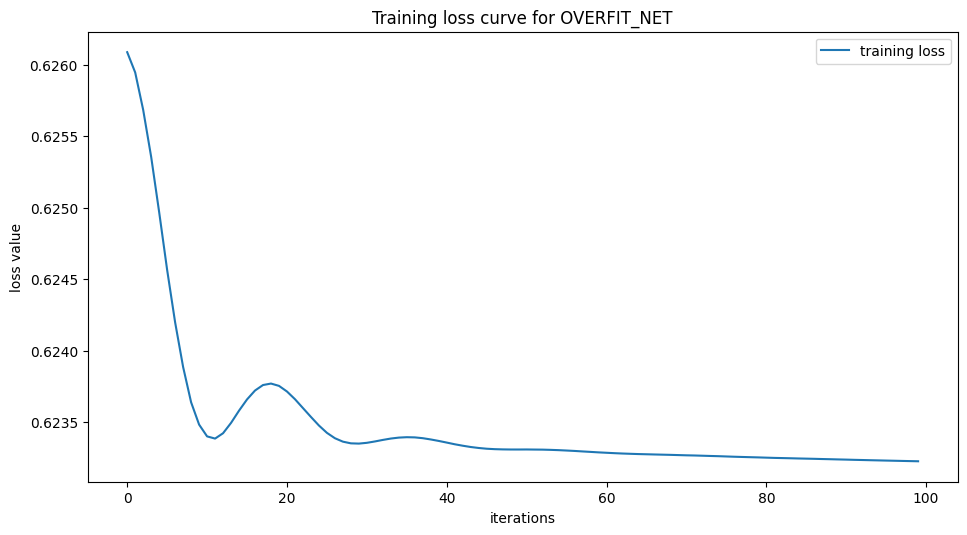

In [395]:
%%time

overfit_net = Model().eval()

EPOCH = 100

optimizer = get_optimizer(overfit_net)

train_net(sanity_loader, overfit_net, optimizer, EPOCH)

torch.save(overfit_net.state_dict(), "overfit_net.pth")
# torch.save(untrained_net.state_dict(), "untrained_net.pth")

Now we run it on its own image and a random image in the set to compare its results

torch.Size([256, 1152])
tensor(0.1469, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.1462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3155)


TypeError: custom_loss() missing 6 required positional arguments: 'imL', 'imR', 'dL', 'dR', 'recImL', and 'recImR'

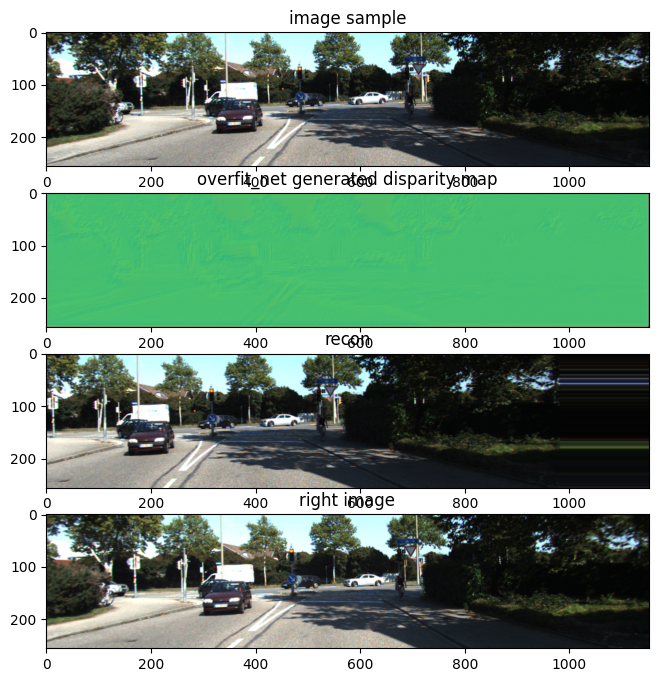

In [396]:
overfit_net.eval()

im1, imR = KittiStereo(
    DATASET_PATH, 
    split = 'train',
    transforms = JointCompose([CropToMultiple(128), ToTensor()]),
)[15]


im1 = im1.cuda()

dL1 = overfit_net.forward(im1[None])[0, 0]

def increase_disparity_diff(dMap):
    dMap = dMap / torch.max(dMap)
    dMap = torch.float_power(dMap, 140)*50
    return dMap

# tF.convert_image_dtype
# dL1 = tF.convert_image_dtype(increase_disparity_diff(dL1))


print(dL1.shape)
print(torch.max(dL1), torch.mean(dL1))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(4,1,1)
plt.title('image sample')
ax.imshow(im1.cpu().permute(1, 2, 0).numpy())
ax = fig.add_subplot(4,1,2)
plt.title("overfit_net generated disparity map")
ax.imshow(dL1.cpu().detach().numpy())
ax = fig.add_subplot(4, 1, 3)
plt.title("recon")
ax.imshow(reconStruct(im1[None].cpu().detach(), dL1[None].cpu().detach(), False)[0].permute(1, 2, 0))
ax = fig.add_subplot(4, 1, 4)
plt.title("right image")
ax.imshow(imR.permute(1, 2, 0))

print(appearance_loss(imR[None], reconStruct(im1[None].cpu().detach(), dL1[None].cpu().detach(), False), 1))

print(custom_loss())
# ax = fig.add_subplot(2,3,3)
# plt.title("ground truth disparity map")
# ax.imshow(gt1)
# ax = fig.add_subplot(2,3,4)
# plt.title('image sample')
# ax.imshow(im2)
# ax = fig.add_subplot(2,3,5)
# plt.title("overfit_net generated disparity map")
# ax.imshow(dL2)
# ax = fig.add_subplot(2,3,6)
# plt.title("ground truth disparity map")
# ax.imshow(gt2)



## Trained Model

In [ ]:
%%time

trained_net = copy.deepcopy(untrained_net)

EPOCH = 10

optimizer = get_optimizer(trained_net)

train_net(train_loader, trained_net, optimizer, EPOCH)

torch.save(trained_net.state_dict(), "trained_net.pth")

NameError: name 'untrained_net' is not defined

Similarly, we compare visually the results compared to the overfit image and another random image

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

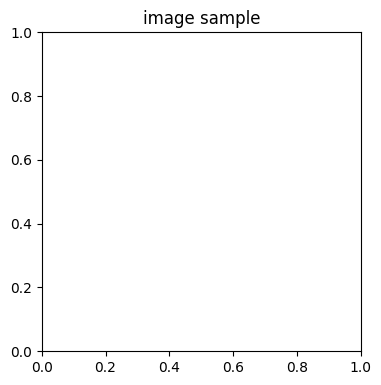

In [ ]:
#im1, dL1, gt1 = 
#im2, dL2, gt2 = 

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(2,3,1)
plt.title('image sample')
ax.imshow(im1)
ax = fig.add_subplot(2,3,2)
plt.title("trained_net generated disparity map")
ax.imshow(dL1)
ax = fig.add_subplot(2,3,3)
plt.title("ground truth disparity map")
ax.imshow(gt1)
ax = fig.add_subplot(2,3,4)
plt.title('image sample')
ax.imshow(im2)
ax = fig.add_subplot(2,3,5)
plt.title("trained_net generated disparity map")
ax.imshow(dL2)
ax = fig.add_subplot(2,3,6)
plt.title("ground truth disparity map")
ax.imshow(gt2)


## Evaluation

## Conclusion

TODO